In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.integrate import solve_ivp
plt.style.use('seaborn-darkgrid')
import datetime
from copy import deepcopy
from scipy.stats import norm
from scipy.optimize import differential_evolution
import pdb
from IPython.core.display import HTML
from math import ceil, floor
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import chain
from scipy.signal import savgol_filter
from scipy.special import expit
from scipy.integrate import solve_ivp
from itertools import product
import matplotlib as mpl
from utils import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Fetch data
! rm time_series_covid19_deaths_US.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv
! rm Global_Mobility_Report.csv*
! wget -nv https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv
! rm time_series_covid19_deaths_global.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

rm: time_series_covid19_deaths_US.csv*: No such file or directory
2020-06-05 08:44:51 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv [1250822/1250822] -> "time_series_covid19_deaths_US.csv" [1]
rm: Global_Mobility_Report.csv*: No such file or directory
2020-06-05 08:45:00 URL:https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv [29703428/29703428] -> "Global_Mobility_Report.csv" [1]
rm: time_series_covid19_deaths_global.csv*: No such file or directory
2020-06-05 08:45:01 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv [94844/94844] -> "time_series_covid19_deaths_global.csv" [1]


<h1>SIRD model with social distancing</h1>

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - \frac{I}{T_{inf}}
$$

$$
\frac{dX}{dt} = \gamma_XI
$$

More details in the whitepaper

<h1>NYC</h1>

In [4]:
# Fetch death data for NYC from JHU
raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_nyc = []
date = deepcopy(start_date)
df_nyc = raw_data_us[raw_data_us['Combined_Key'].str.contains("New York City")]
df_nyc_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_nyc.extend(df_nyc[date.strftime(date_format)].values)
    date = date + datetime.timedelta(days=1)

deaths_time_series_nyc = np.array(deaths_time_series_nyc)
deaths_time_series_nyc[1:] = np.diff(deaths_time_series_nyc)

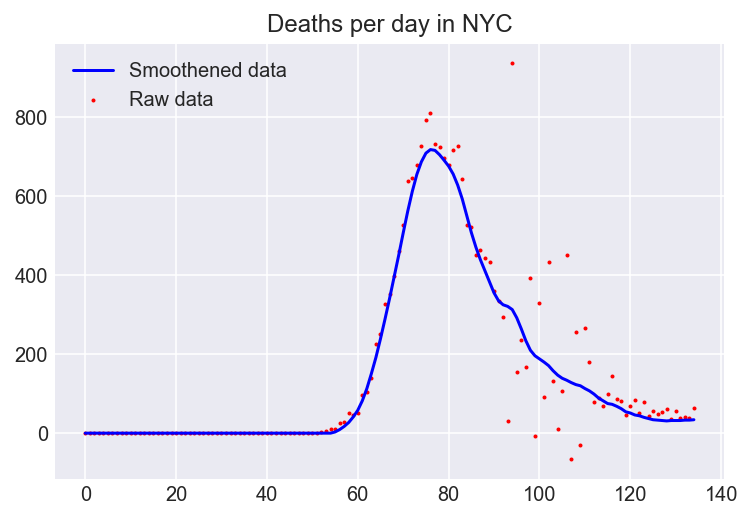

In [5]:
# Data visualization
smooth_data_nyc = smoothen(smoothen(smoothen(smoothen(smoothen(deaths_time_series_nyc, 1), 1), 1), 1), 1)

plt.scatter(np.arange(smooth_data_nyc.shape[0]), deaths_time_series_nyc, label="Raw data", s=1, c='red')
plt.plot(smooth_data_nyc, label="Smoothened data", c='blue')
plt.legend()
plt.title("Deaths per day in NYC")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


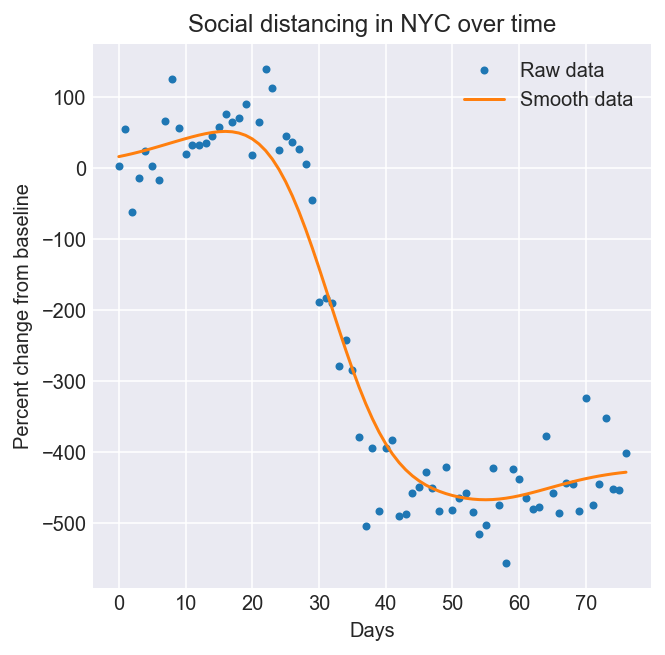

In [9]:
# Preprocess social distancing data from Google
start_date_sd = datetime.date(2020, 2, 15)
end_date_sd   = datetime.date(2020, 5, 1)
date_format_sd = "%Y-%m-%d"
smoothening_factor = 6

df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=True)
df_sd = df_sd[df_sd['country_region_code'] == 'US']

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

# Counties which NYC covers -- population data from Wikipedia
counties = {"New York County" : 1628706, 
            "Kings County"    : 2559903, 
            "Bronx County"    : 1418207, 
            "Queens County"   : 2253858}

total_pop = 0.
for c in counties.keys():
    total_pop += counties[c]

agg_sd_nyc = {}
for cat in categories:
    agg_sd_nyc[cat] = []

curr_date = deepcopy(start_date_sd)

# Get weighted average of social distancing from counties in NYC
while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    
    val = {}
    
    for c in counties.keys():
        df_county = df_sd_curr[df_sd_curr["sub_region_2"] == c]
        
        for cat in categories:
            if cat in val:
                val[cat] += counties[c] * np.array(df_county[cat])[0]
            else:
                val[cat] = counties[c] * np.array(df_county[cat])[0]
                
    for cat in categories:
        val[cat] /= total_pop
        agg_sd_nyc[cat].append(val[cat])
    
    curr_date = curr_date + datetime.timedelta(days=1)
    
agg_sd_nyc["total"] = np.zeros(len(agg_sd_nyc[categories[0]]))

# Get the total
for cat in agg_sd_nyc.keys():
    agg_sd_nyc[cat] = np.array(agg_sd_nyc[cat])
    agg_sd_nyc["total"] += agg_sd_nyc[cat]
    
plt.figure(figsize=(5,5))
plt.plot(agg_sd_nyc["total"], '.', label="Raw data")

# Plot the array
for label in agg_sd_nyc.keys():
    agg_sd_nyc[label] = smoothen(agg_sd_nyc[label], smoothening_factor)
#     plt.plot(agg_sd_nyc[label], label=label)

plt.plot(agg_sd_nyc["total"], label="Smooth data")

plt.title("Social distancing in NYC over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

,Breakpoint,Train Loss,T_inf,sd_offset,pop,gamma_x,I_init,offset,padded_sd,R_max,R_min
0,60.0,6.067822,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.057143,0.800000
0,64.0,11.865035,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.285714,0.950000
0,68.0,15.969190,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.342857,0.950000
0,72.0,21.862933,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.800000
0,76.0,22.959930,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.850000
0,80.0,22.654487,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.883333
0,90.0,21.702410,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.883333
0,100.0,21.063845,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.883333
0,130.0,17.917554,5.0,23.0,8400000.0,0.0016,0.000074,40.0,"[15.806769685976109, 15.806769685976109, 15.80...",2.400000,0.883333


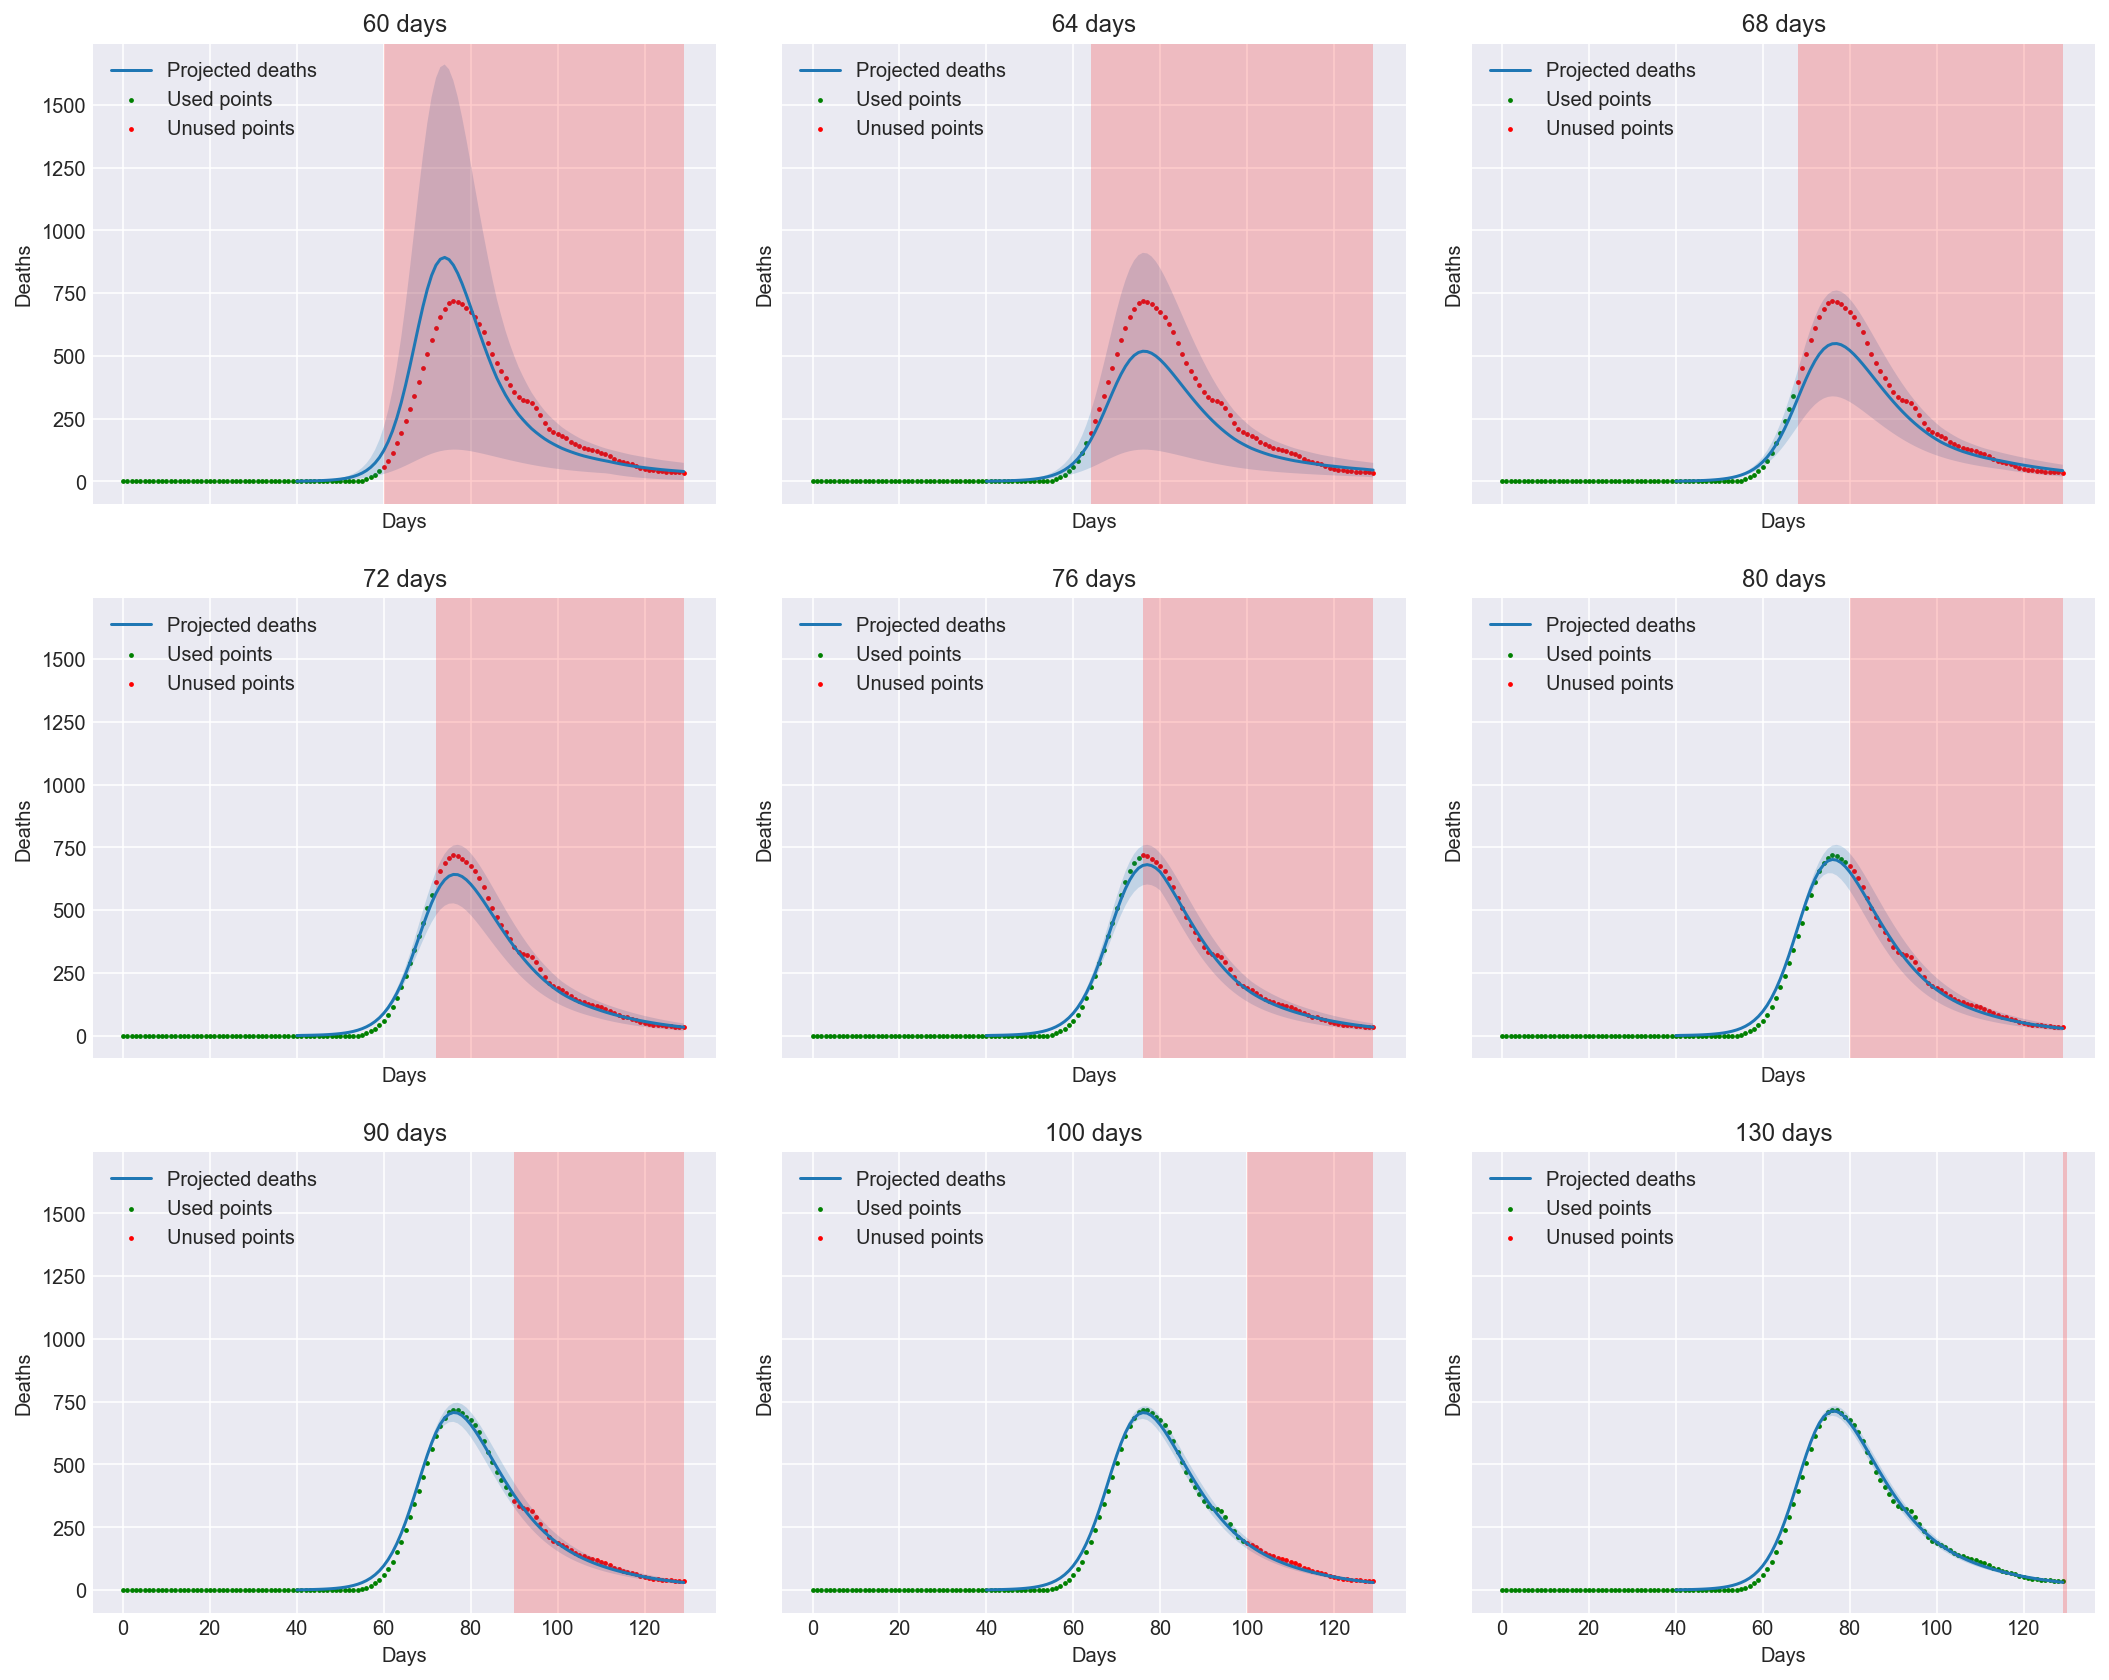

In [6]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_nyc,
                   breakpoints=[60, 64, 68, 72, 76, 80, 90, 100, smooth_data_nyc.shape[0]],
                   plot_title="NYC",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 8.4e6,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 7.4e-5, 
                       "offset"    : 40,
                       "padded_sd" : padded_sd
                   },
                   var_param_vals={
                       "R_max": np.linspace(2.0, 2.8, 15),
                       "R_min": np.linspace(0.8, 0.95, 10),
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset", "padded_sd"],
                  loss_factor=800)

<h1>Spain</h1>

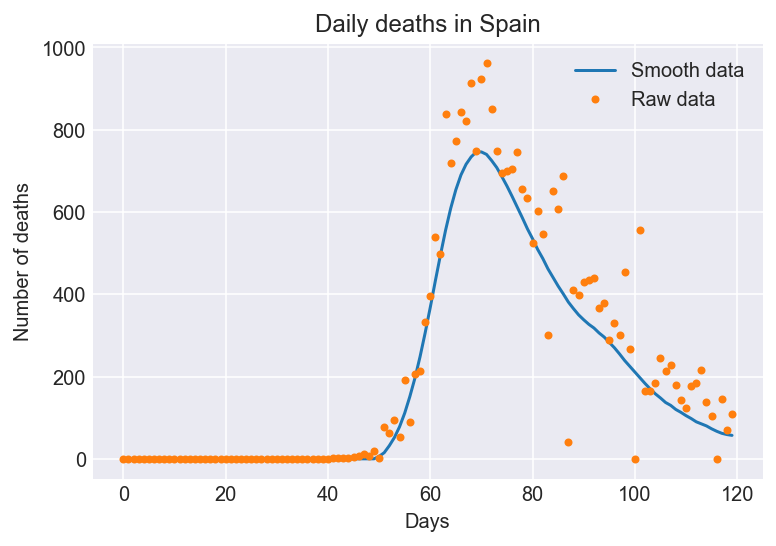

In [13]:
# Get the death data
df_global = pd.read_csv("time_series_covid19_deaths_global.csv")
date_format = "%-m/%-d/%y"
start_date_global = datetime.date(2020, 1, 22)
end_date_global = datetime.date(2020, 5, 27)

df_spain = df_global[df_global["Country/Region"] == "Spain"]

data_spain = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_spain.append(df_spain[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)

data_spain = data_spain[:120]
data_spain[1:] = np.diff(data_spain)
smooth_data_spain = deepcopy(data_spain)

for i in range(1, 15):
    smooth_data_spain = smoothen(smooth_data_spain, 1)

plt.plot(smooth_data_spain, label="Smooth data")
plt.plot(data_spain, '.', label="Raw data")
# plt.plot(smooth_data_spain, label="Smoothened data")
plt.title("Daily deaths in Spain")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

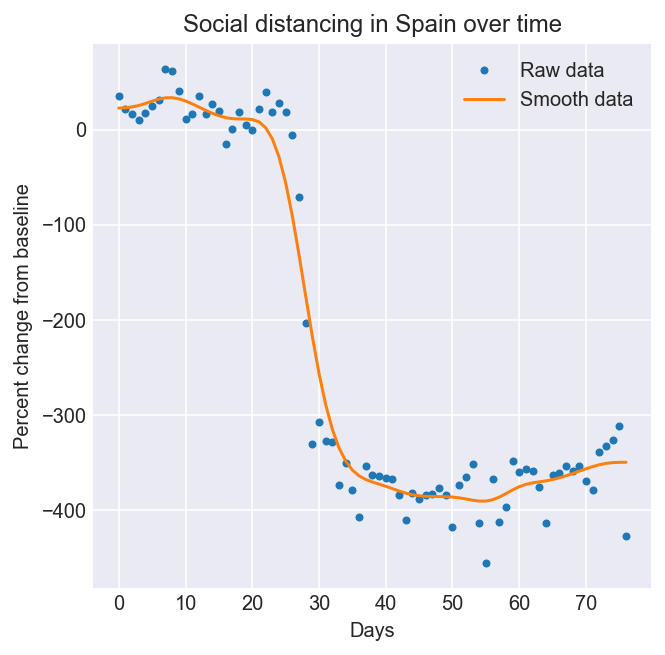

In [14]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd['country_region_code'] == 'ES']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_spain = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_spain.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_spain = np.array(agg_sd_spain)
plt.figure(figsize=(5,5))
plt.plot(agg_sd_spain, '.', label="Raw data")

for i in range(5):
    agg_sd_spain = smoothen(smoothen(agg_sd_spain, 1), 1)

# agg_sd_spain = np.maximum(np.ones_like(agg_sd_spain) * agg_sd_spain[-1], agg_sd_spain)

# for i in range(5):
#     padded_sd = smoothen(smoothen(padded_sd, 1), 1)
#     plt.plot(padded_sd, label="Smooth data {}".format(i + 6))

plt.plot(agg_sd_spain, label="Smooth data")
plt.title("Social distancing in Spain over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

,Breakpoint,Train Loss,T_inf,sd_offset,pop,gamma_x,I_init,offset,padded_sd,R_max,R_min
0,60.0,25.983941,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.947368,0.950000
0,64.0,28.799237,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.750000
0,68.0,27.587417,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.700000
0,72.0,26.936141,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.716667
0,76.0,27.067010,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.750000
0,80.0,26.641872,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.766667
0,84.0,26.040340,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.766667
0,90.0,25.653211,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.766667
0,120.0,27.020834,5.0,23.0,46900000.0,0.0016,0.000013,25.0,"[22.534350886063567, 22.534350886063567, 22.53...",1.984211,0.783333


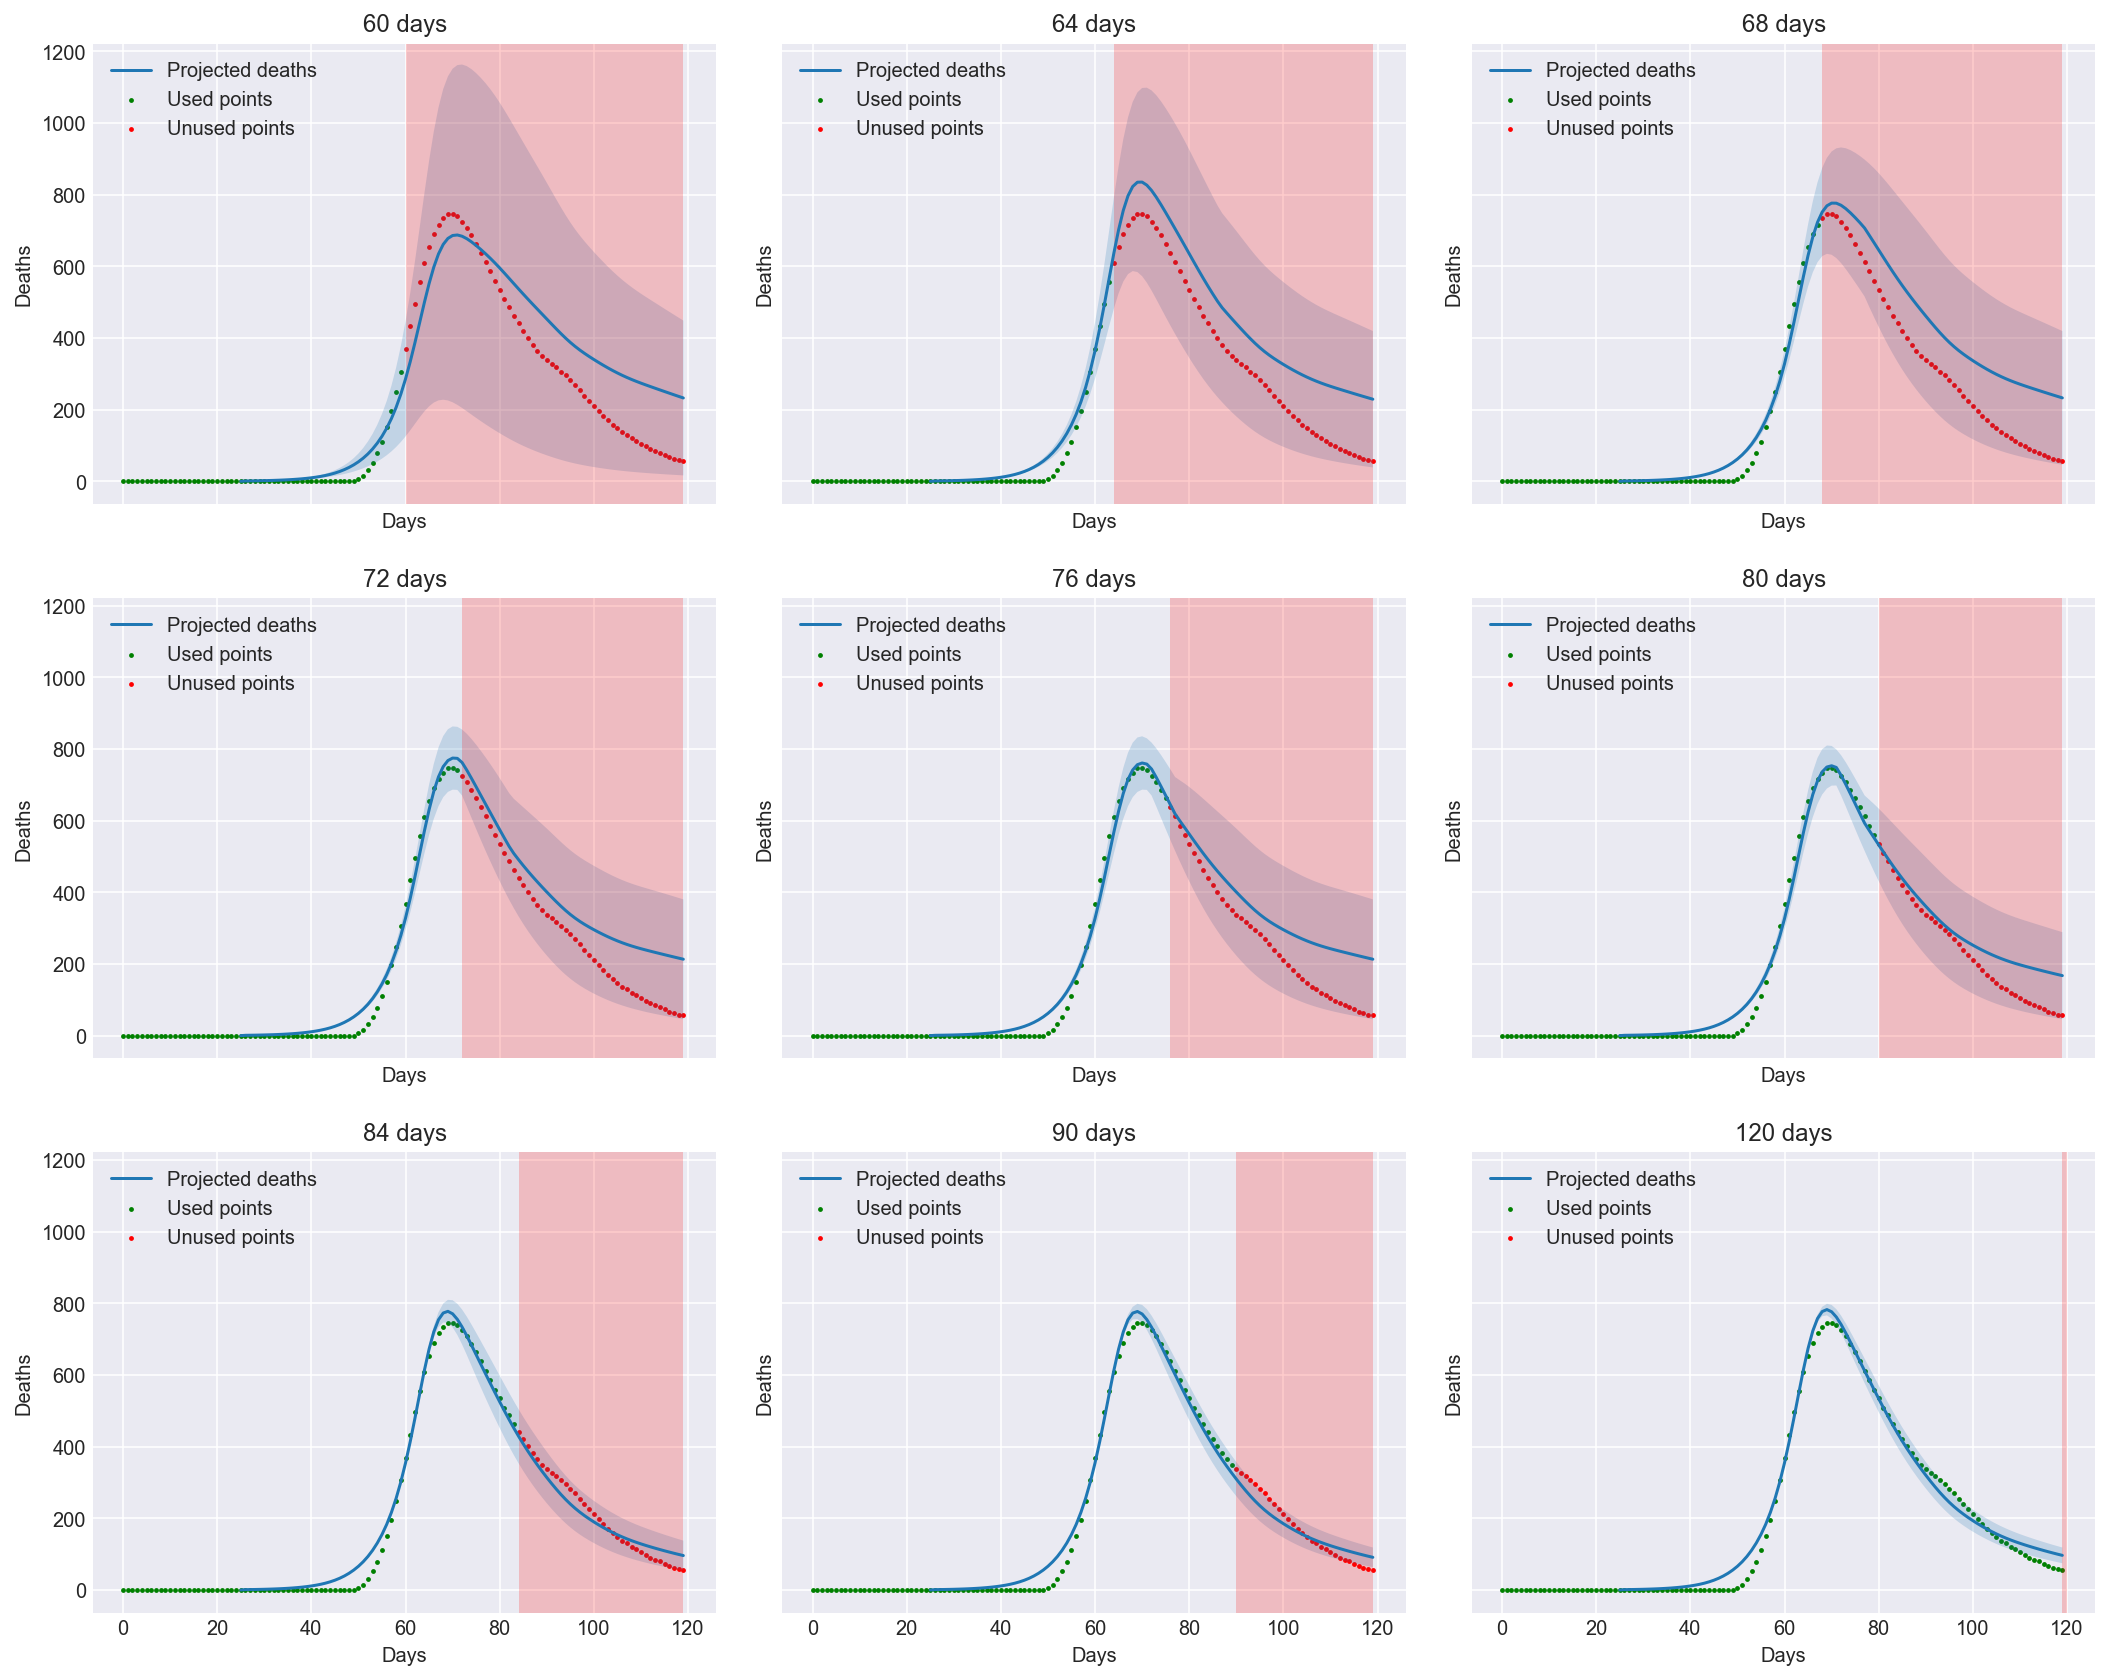

In [18]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_spain[0], agg_sd_spain))

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_spain,
                   breakpoints=[60, 64, 68, 72, 76, 80, 84, 90, smooth_data_spain.shape[0]],
                   plot_title="Spain",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 4.69e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 1.3e-5, 
                       "offset"    : 25,
                       "padded_sd" : padded_sd
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.8, 2.5, 20),
                       "R_min": np.linspace(0.7, 0.95, 16)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset", "padded_sd"],
                  loss_factor=1000)

<h1>Italy</h1>

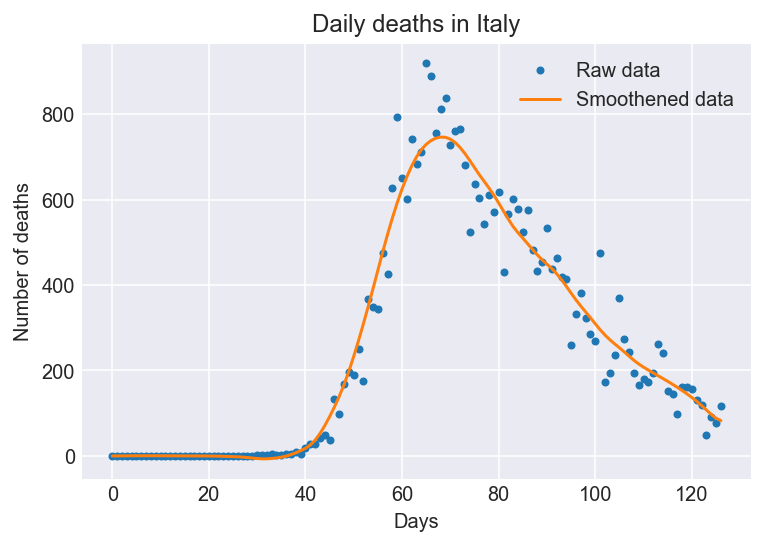

In [20]:
# Get the death data
df_italy = df_global[df_global["Country/Region"] == "Italy"]

data_italy = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_italy.append(df_italy[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_italy[1:] = np.diff(data_italy)
smooth_data_italy = smoothen(smoothen(savgol_filter(data_italy, 37, 3), 1), 1)

plt.plot(data_italy, '.', label="Raw data")
plt.plot(smooth_data_italy, label="Smoothened data")
plt.title("Daily deaths in Italy")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


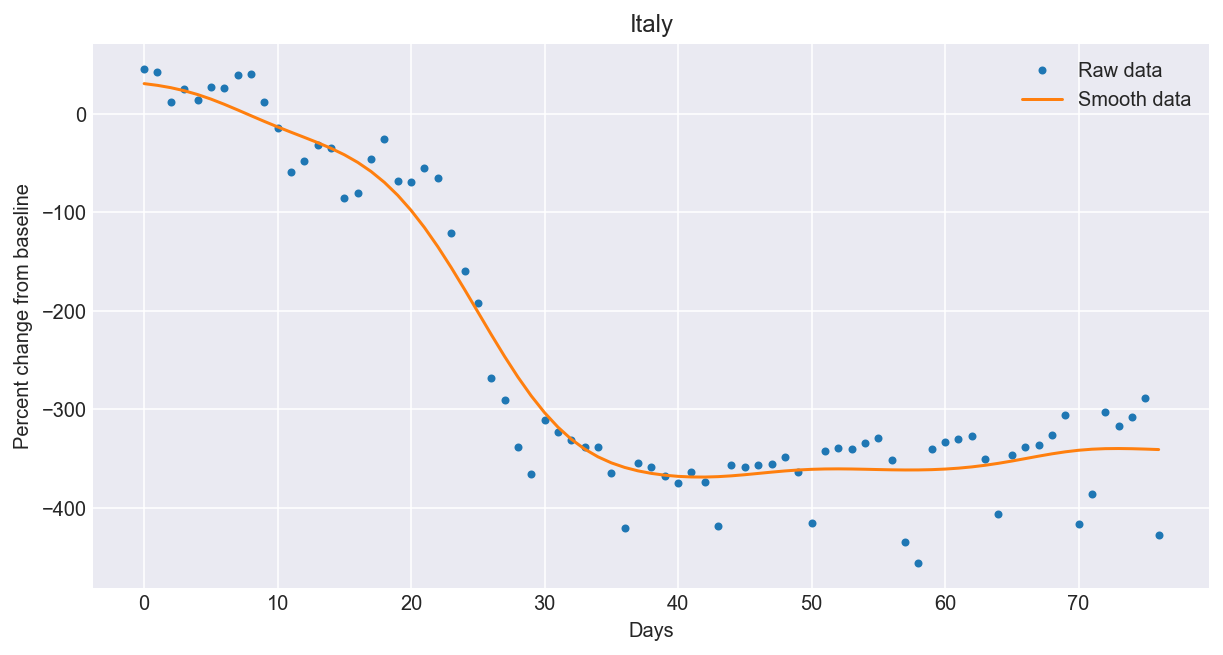

In [21]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'IT']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_italy = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_italy.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_italy = np.array(agg_sd_italy)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_italy, '.', label="Raw data")
agg_sd_italy = smoothen(smoothen(savgol_filter(agg_sd_italy, 37, 6), 3), 3)
plt.plot(agg_sd_italy, label="Smooth data")
plt.title("Italy")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

,Breakpoint,Train Loss,T_inf,sd_offset,pop,gamma_x,I_init,offset,padded_sd,R_max,R_min
0,60.0,22.953867,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.989474,0.500000
0,64.0,36.305373,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.989474,0.500000
0,68.0,37.925772,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.989474,0.500000
0,72.0,44.126367,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.886842
0,76.0,42.960953,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.861053
0,80.0,41.970638,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.886842
0,90.0,39.117682,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.886842
0,100.0,36.874755,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.886842
0,127.0,40.938191,5.0,23.0,60400000.0,0.0016,0.000011,18.0,"[30.853523831085408, 30.853523831085408, 30.85...",1.915789,0.861053


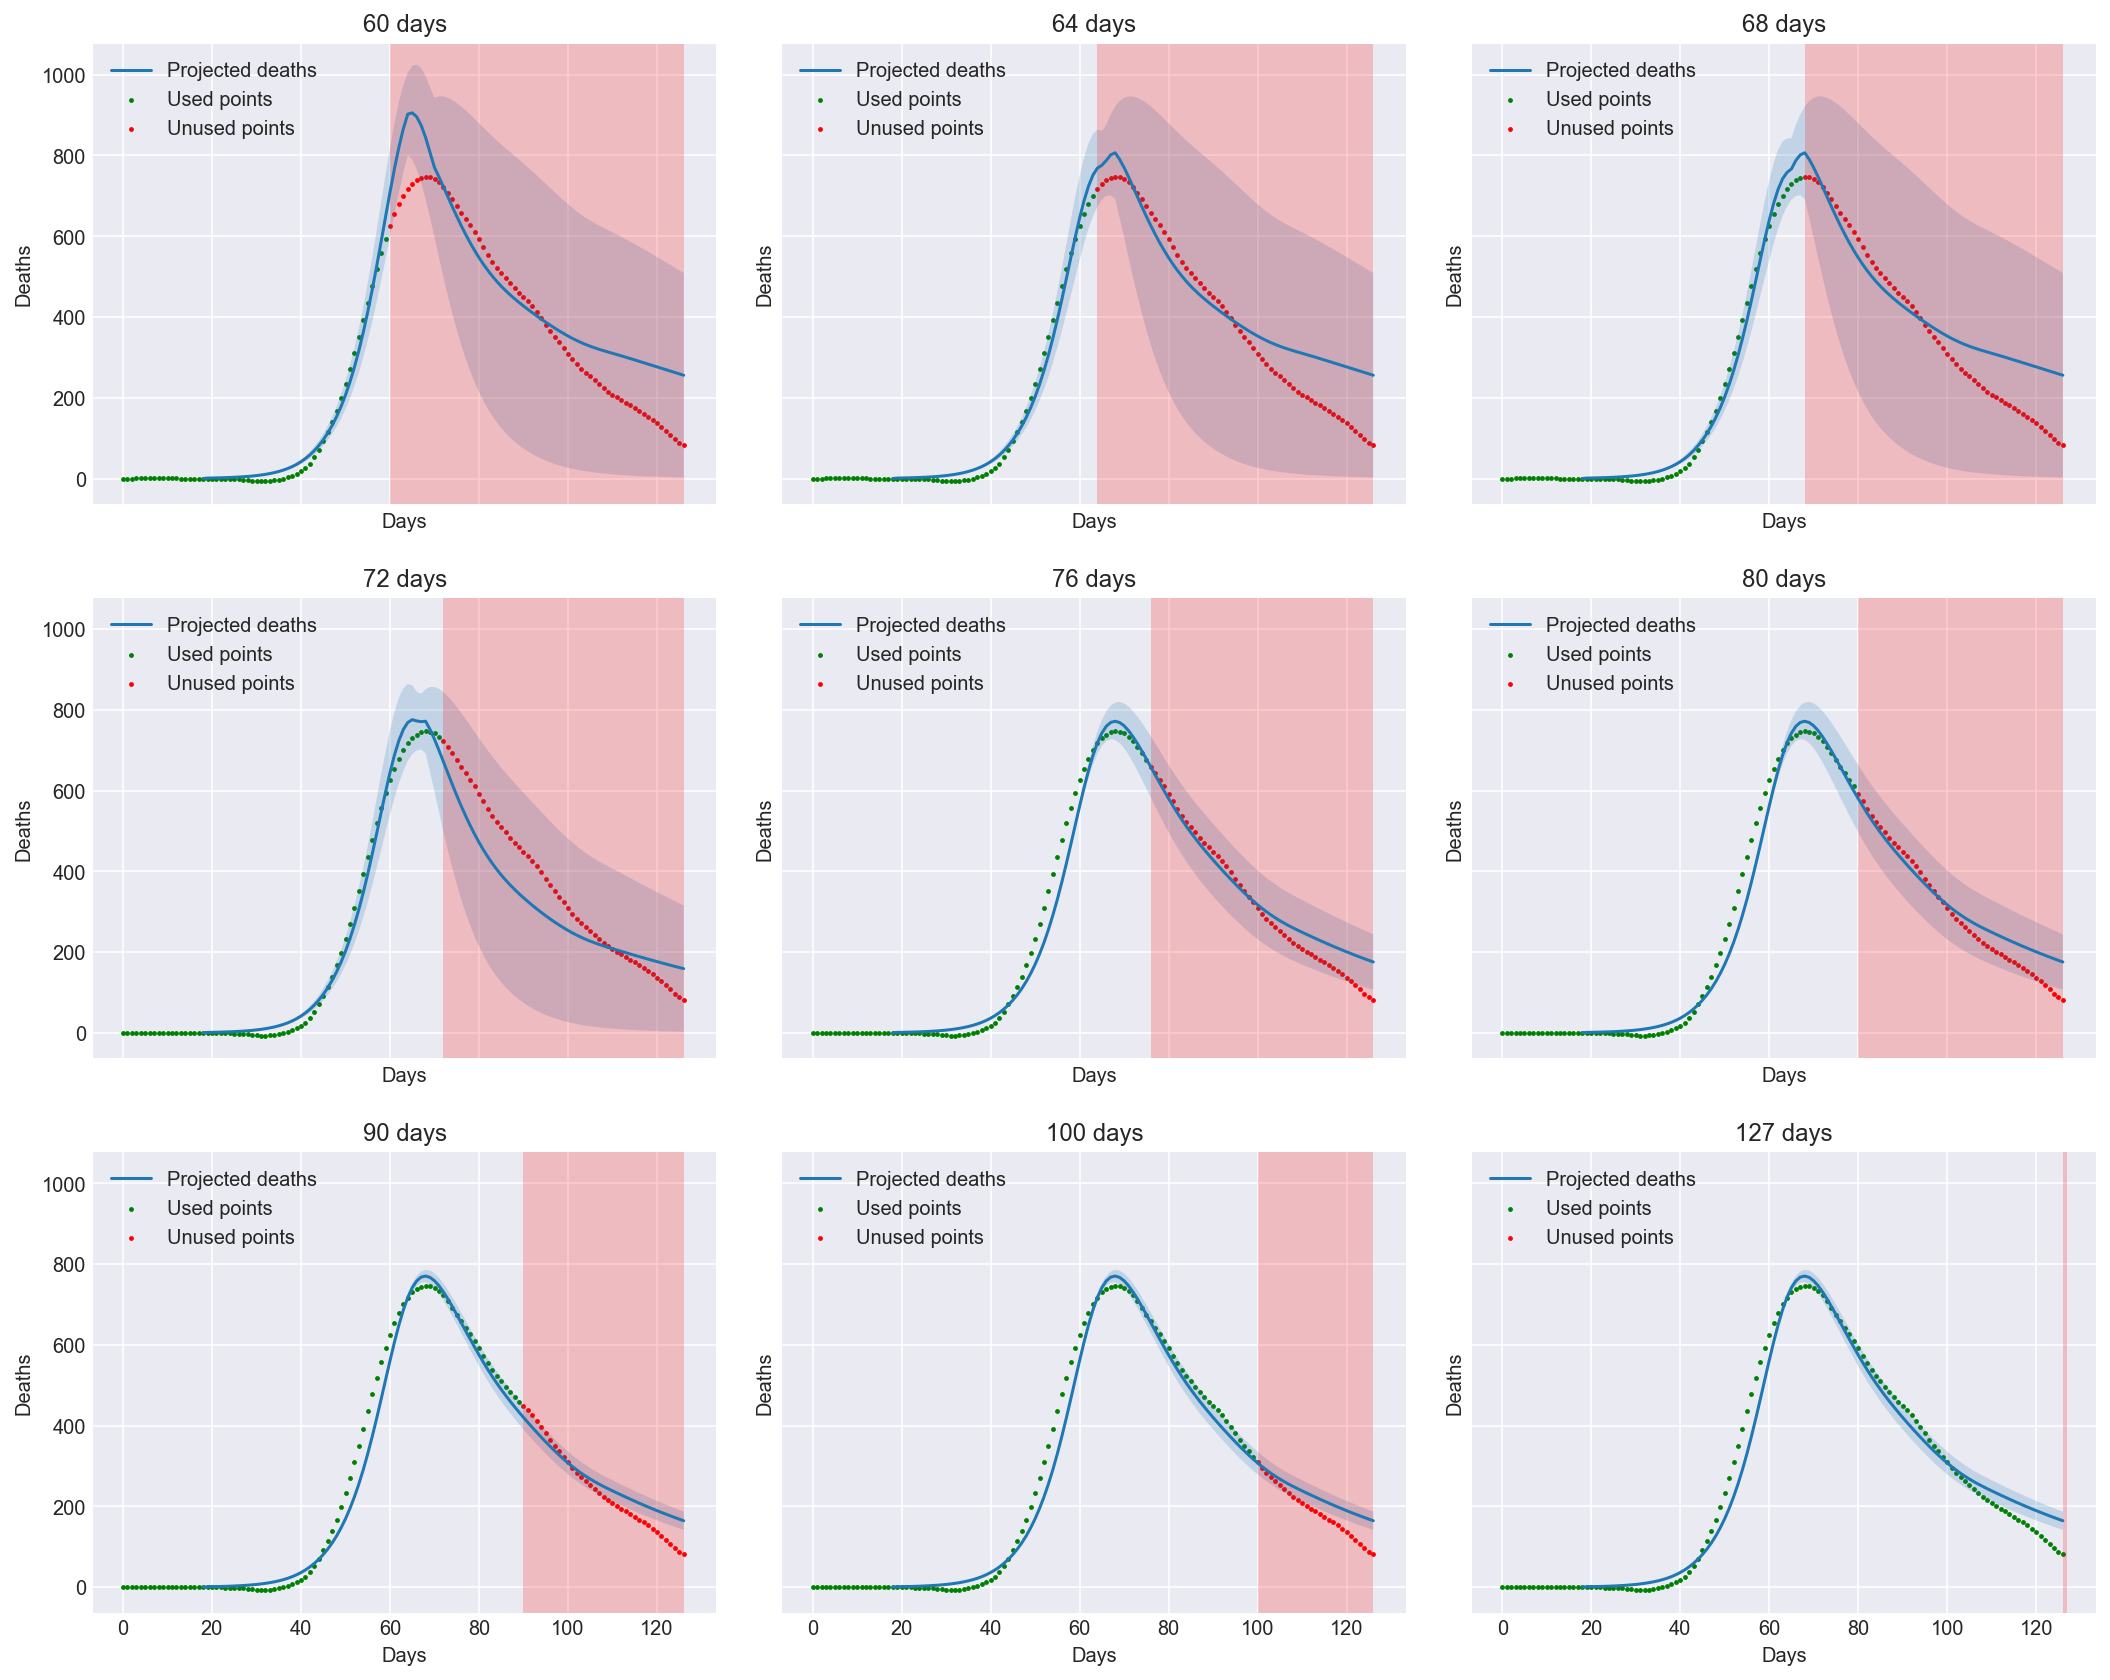

In [22]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_italy[0], agg_sd_italy)) 

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_italy,
                   breakpoints=[60, 64, 68, 72, 76, 80, 90, 100, smooth_data_italy.shape[0]],
                   plot_title="Italy",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 6.04e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 1.1e-5, 
                       "offset"    : 18,
                       "padded_sd" : padded_sd
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.4, 2.8, 20),
                       "R_min": np.linspace(0.5, 0.99, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset", "padded_sd"],
                  loss_factor=800)

<h1>Maharashtra</h1>

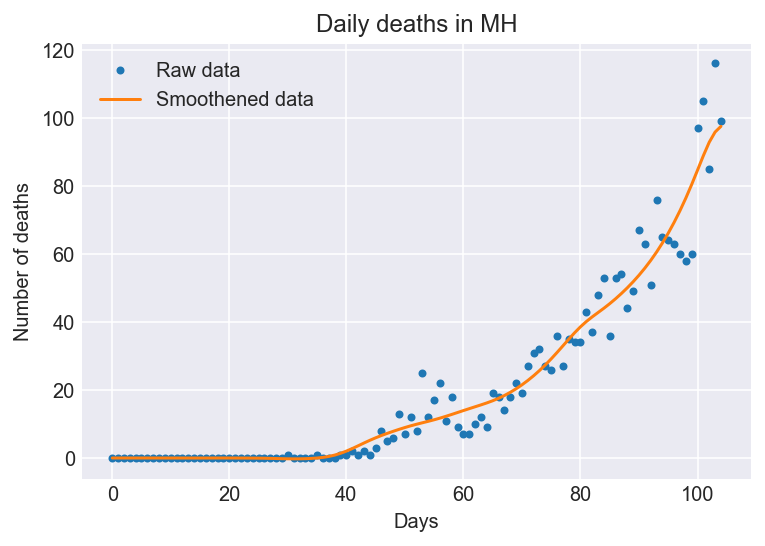

In [23]:
# Get death data for MH
fetcher = DataFetcherState()
fetcher.fetch()
data_mh = np.array(fetcher.data['mh']['deceased'], dtype=float) # Starting date is 14th March
data_mh = np.concatenate((np.zeros(27), data_mh))

smooth_data_mh = smoothen(smoothen(smoothen(smoothen(savgol_filter(data_mh, 37, 3), 1), 1), 1), 1)
plt.plot(data_mh, '.', label="Raw data")
plt.plot(smooth_data_mh, label="Smoothened data")
plt.title("Daily deaths in MH")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

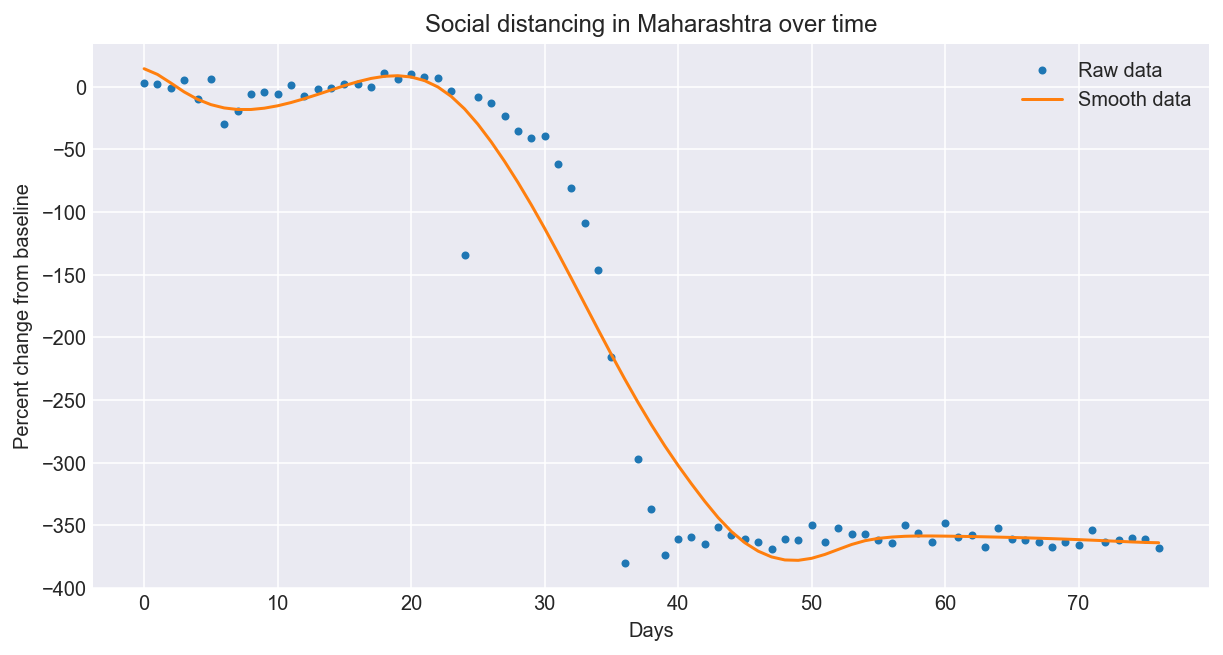

In [24]:
# Get social distancing data for MH
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd["sub_region_1"] == "Maharashtra"]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_mh = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_mh.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_mh = np.array(agg_sd_mh)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_mh, '.', label="Raw data")
agg_sd_mh = smoothen(smoothen(savgol_filter(agg_sd_mh, 37, 3), 1), 1)
plt.plot(agg_sd_mh, label="Smooth data")
plt.title("Social distancing in Maharashtra over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

,Breakpoint,Train Loss,T_inf,sd_offset,pop,gamma_x,I_init,offset,padded_sd,R_max,R_min
0,80.0,4.189188,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.631579,1.100000
0,84.0,3.997580,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.631579,1.100000
0,88.0,3.873234,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.631579,1.110526
0,92.0,3.802881,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.631579,1.121053
0,96.0,3.818784,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.631579,1.131579
0,103.0,4.072718,5.0,23.0,114200000.0,0.0016,0.000005,40.0,"[14.399057448503493, 14.399057448503493, 14.39...",1.573684,1.215789


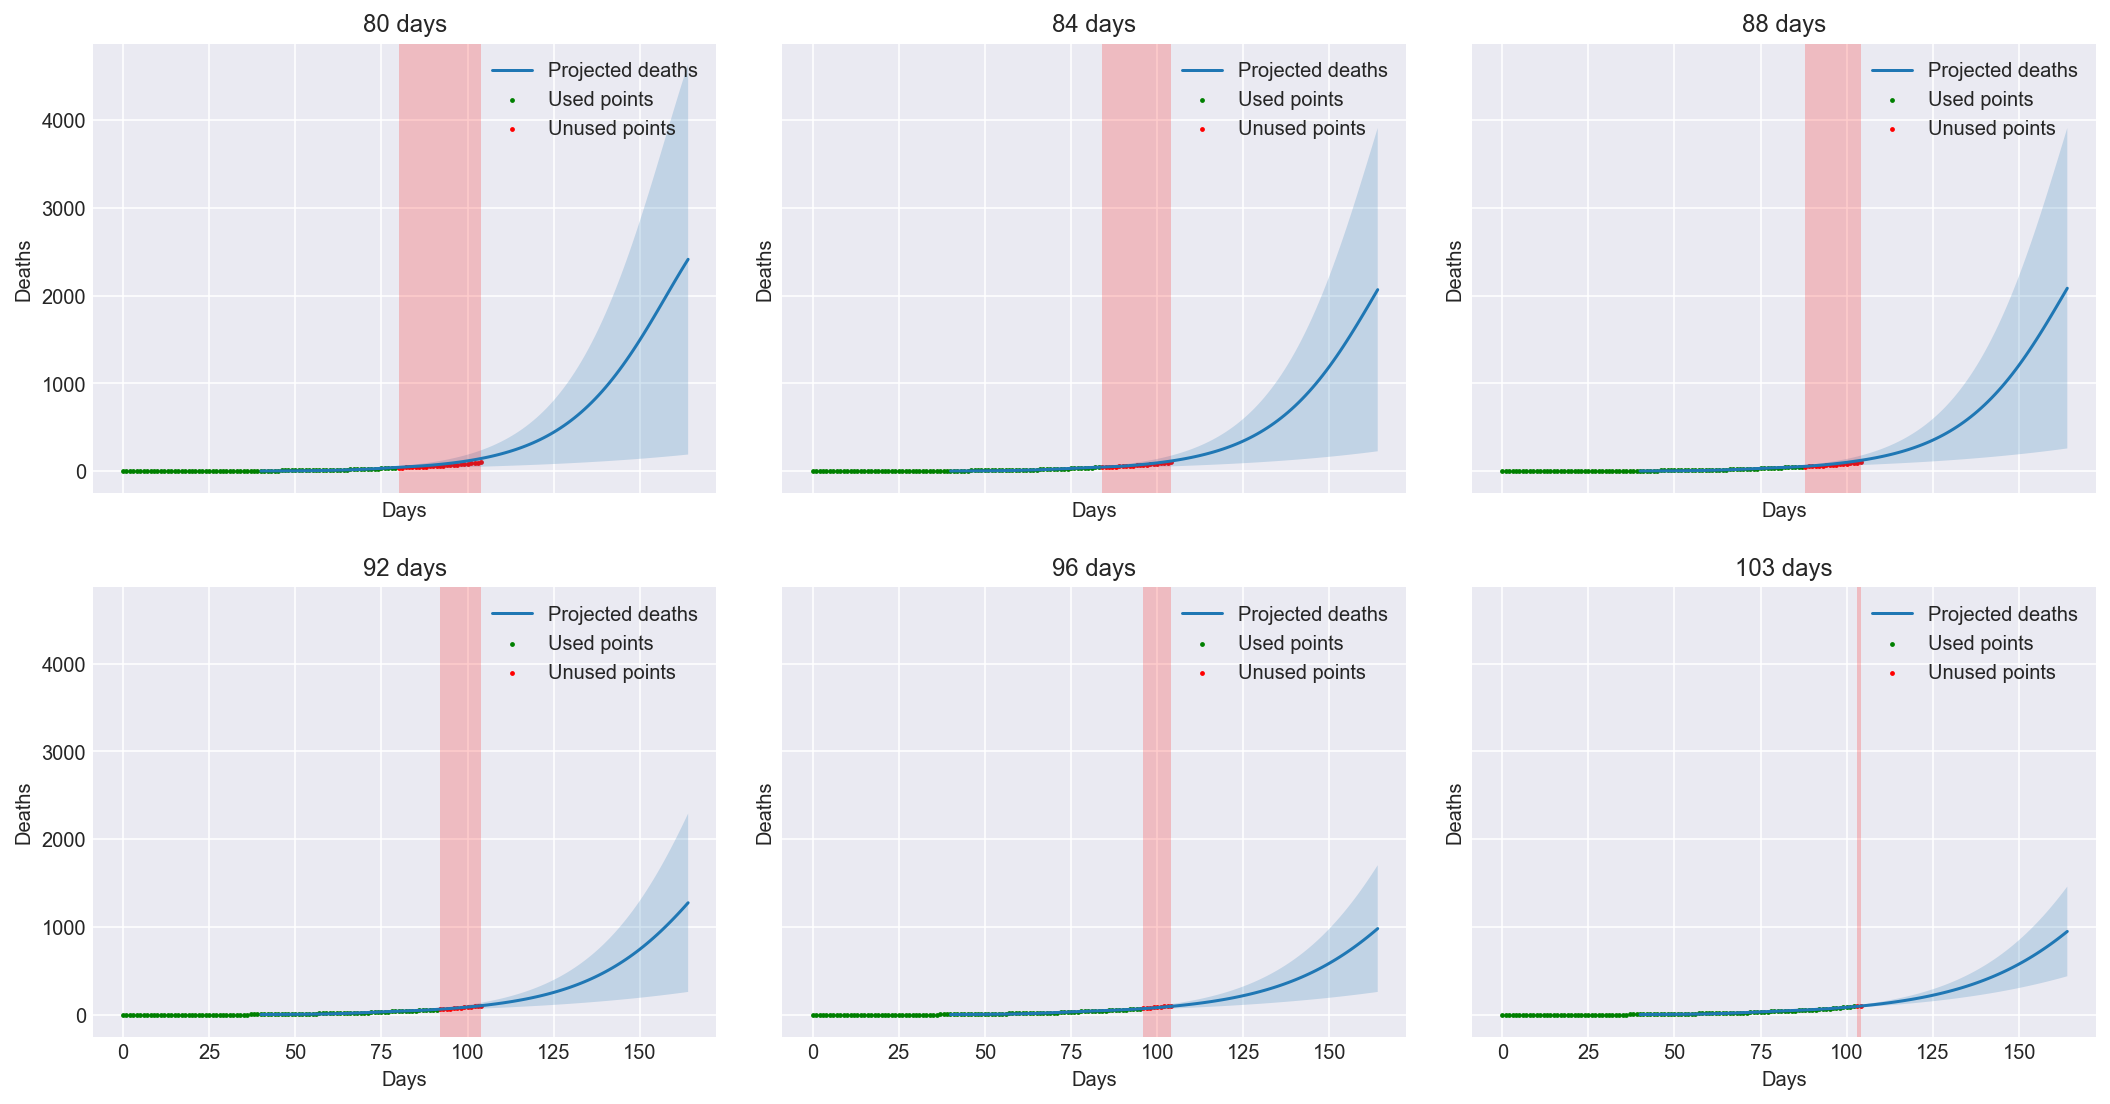

In [25]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_mh[0], agg_sd_mh)) 

max_len = smooth_data_mh.shape[0]

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_mh,
                   breakpoints=[80, 84, 88, 92, 96, 103],
                   plot_title="Maharashtra",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 11.42e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 5.47e-6, 
                       "offset"    : 40,
                       "padded_sd" : padded_sd
                   },
                   var_param_vals={
#                        "offset": np.linspace(40, 50, 2),
                       "R_max": np.linspace(1.4, 2.5, 20),
                       "R_min": np.linspace(1.1, 1.3, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset", "padded_sd"],
                  loss_factor=100,
                  future_preds=60)

<h1>Delhi</h1>

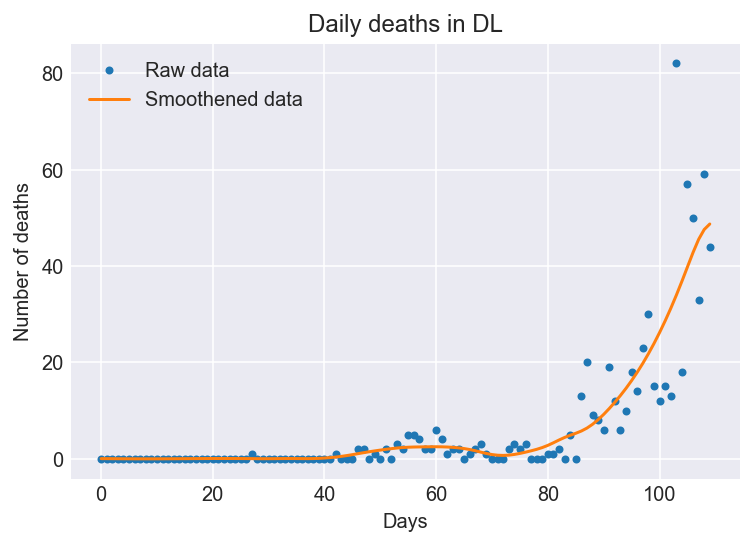

In [7]:
# Get death data for DL
fetcher = DataFetcherState()
fetcher.fetch()
data_dl = np.array(fetcher.data['dl']['deceased'], dtype=float) # Starting date is 14th March
data_dl = np.concatenate((np.zeros(27), data_dl))

smooth_data_dl = smoothen(smoothen(smoothen(smoothen(savgol_filter(data_dl, 37, 3), 1), 1), 1), 1)
plt.plot(data_dl, '.', label="Raw data")
plt.plot(smooth_data_dl, label="Smoothened data")
plt.title("Daily deaths in DL")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

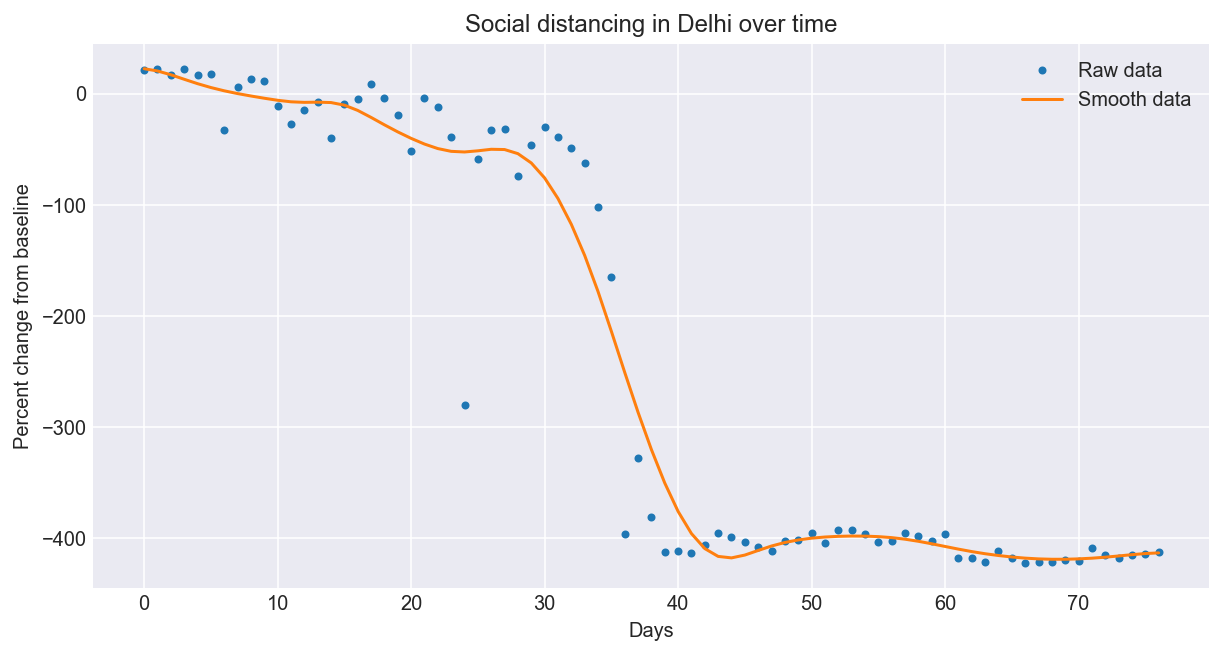

In [10]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df_sd = df_sd[df_sd["sub_region_1"] == "Delhi"]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_dl = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_dl.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_dl = np.array(agg_sd_dl)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_dl, '.', label="Raw data")
agg_sd_dl = smoothen(smoothen(smoothen(savgol_filter(agg_sd_dl, 21, 3), 1), 1), 1)
plt.plot(agg_sd_dl, label="Smooth data")
plt.title("Social distancing in Delhi over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

,Breakpoint,Train Loss,T_inf,sd_offset,pop,gamma_x,I_init,offset,padded_sd,R_max,R_min
0,102.0,2.794467,5.0,23.0,19000000.0,0.0016,0.000033,60.0,"[22.344070622524622, 22.344070622524622, 22.34...",1.689474,1.3
0,106.0,3.531892,5.0,23.0,19000000.0,0.0016,0.000033,60.0,"[22.344070622524622, 22.344070622524622, 22.34...",1.747368,1.3
0,110.0,3.895878,5.0,23.0,19000000.0,0.0016,0.000033,60.0,"[22.344070622524622, 22.344070622524622, 22.34...",1.805263,1.3


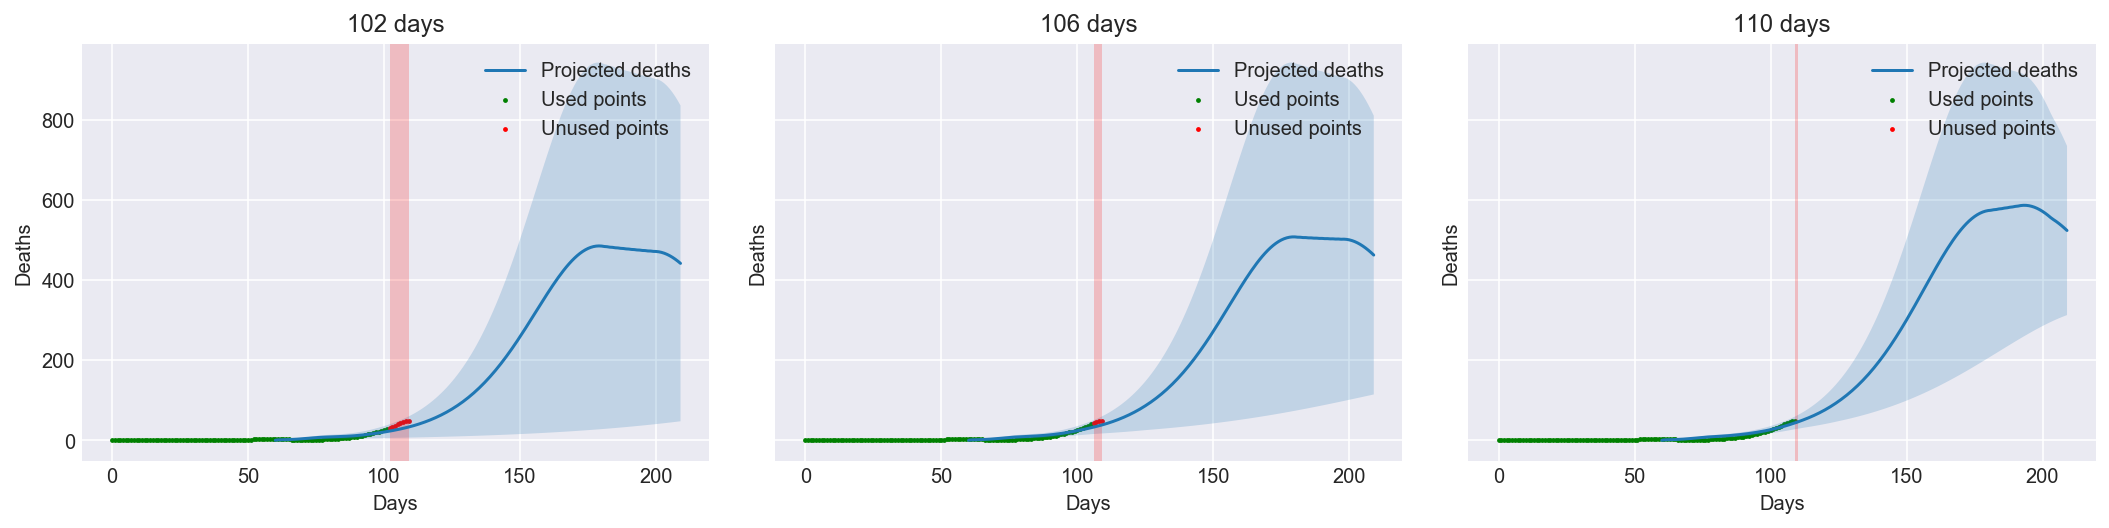

In [17]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_dl[0], agg_sd_dl)) 

max_len = smooth_data_dl.shape[0]

get_model_stats_v2(model=sird_sd, 
                   loss_fun=rmse_loss,
                   data=smooth_data_dl,
                   breakpoints=list(range(max_len - 8, max_len + 1, 4)),
                   plot_title="Delhi",
                   fixed_params={
                       "T_inf"     : 5.0,
                       "sd_offset" : 23,
                       "pop"       : 1.9e7,
                       "gamma_x"   : 1.6e-3,
                       "I_init"    : 3.28e-5, 
                       "offset"    : 60,
                       "padded_sd" : padded_sd
                   },
                   var_param_vals={
                       "R_max": np.linspace(1.4, 2.5, 20),
                       "R_min": np.linspace(1.1, 1.3, 20)
                   },
                  param_order=["offset", "pop", "I_init", "T_inf", "gamma_x", "R_max", "R_min", "sd_offset", "padded_sd"],
                  loss_factor=200,
                  future_preds=100)